We would like to have a box size of at least 2x2x2 nm, or 3x3x3 to be on the save size. Proposes strategy; take smallest molecules, see how many you need to fill this size, and go with this number for all. 

In [2]:
from Parameteriser import LiquidParameteriser

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [20]:
#our smallest molecule is probaby methane
rdk_pmd_100 = LiquidParameteriser.via_rdkit(smiles = 'C', num_lig = 100)
rdk_pmd_100.box_vectors

Quantity(value=([17.512, 0.0, 0.0], [0, 17.512, 0.0], [0, 0, 17.512]), unit=angstrom)

In [21]:
#our smallest molecule is probaby methane
rdk_pmd_256 = LiquidParameteriser.via_rdkit(smiles = 'C', num_lig = 256)
rdk_pmd_256.box_vectors

Quantity(value=([23.22, 0.0, 0.0], [0, 23.22, 0.0], [0, 0, 23.22]), unit=angstrom)

In [22]:
#our smallest molecule is probaby methane
rdk_pmd_512 = LiquidParameteriser.via_rdkit(smiles = 'C', num_lig = 512)
rdk_pmd_512.box_vectors

Quantity(value=([28.735, 0.0, 0.0], [0, 28.735, 0.0], [0, 0, 28.735]), unit=angstrom)

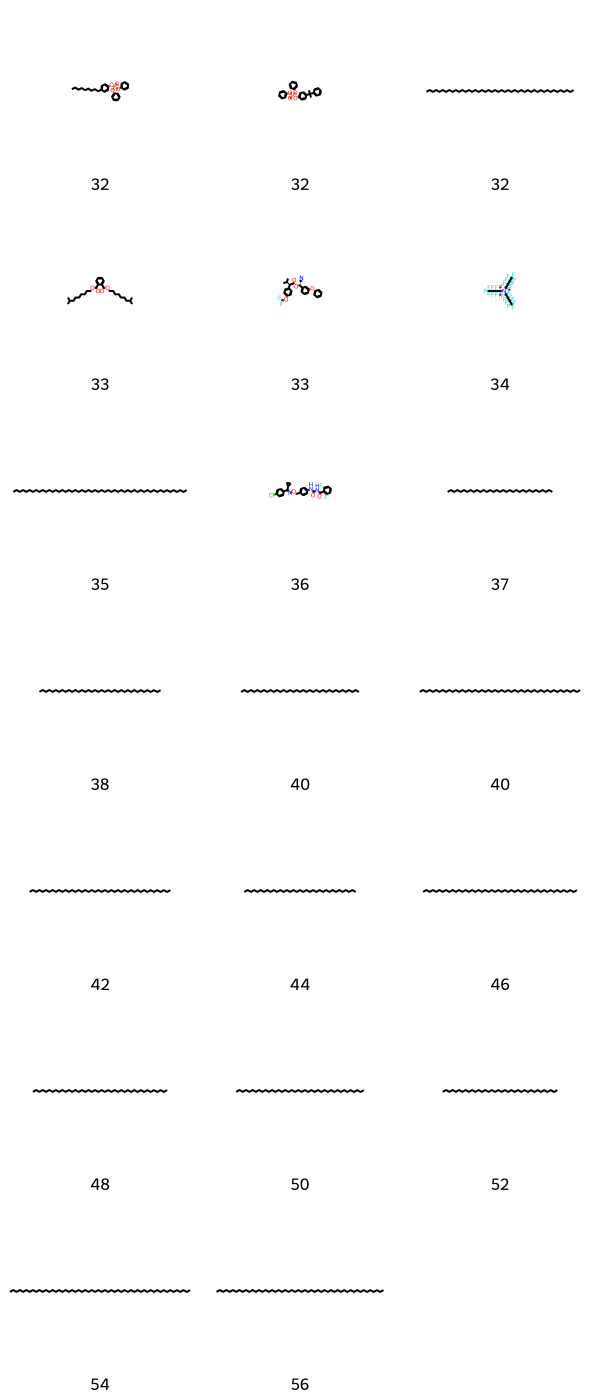

In [50]:
#lets get our biggest molecule (perhaps ignoring the huge alkyl chains? or do both)
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Draw
import numpy as np
df = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/cs_mdfps_schema_experimental_data.csv')
smiles = df['smiles'].values
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
num_atoms = [mol.GetNumAtoms() for mol in mols]
#get top 10, show them
top_10 = np.argsort(num_atoms)[-20:]
top_10_mols = [m for i,m in enumerate(mols) if i in top_10]
Draw.MolsToGridImage(top_10_mols,legends=[str(num_atoms[i]) for i in top_10])


In [130]:
biggest_smiles = smiles[np.argmax(num_atoms)]
biggest_smiles

'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'

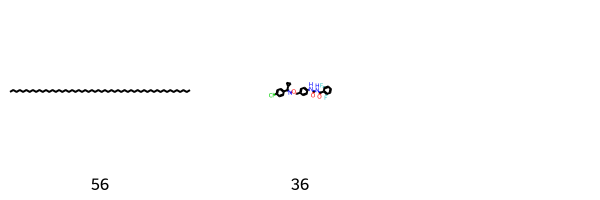

In [55]:
#get the biggest one, and the one with 36 atoms
biggest = np.argmax(num_atoms)
biggest_mol = mols[biggest]
mol_36 = top_10_mols[7]
Draw.MolsToGridImage([biggest_mol,mol_36],legends=[str(num_atoms[biggest]),str(num_atoms[np.where(np.array(num_atoms) == 36)[0][0]])])

In [75]:
from rdkit.Chem import rdDistGeom, AllChem
def distance_from_single_conf(smiles):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    print(rdDistGeom.EmbedMolecule(mol,useRandomCoords=True))
    AllChem.MMFFOptimizeMolecule(mol)
    distmat = Chem.Get3DDistanceMatrix(mol)
    max_dist = np.max(distmat)
    return max_dist
distance_from_single_conf('C'*56)
#max 24 from multiple runs

0


20.991289064584755

In [95]:
smiles_36

'O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(CO/N=C(/c2ccc(Cl)cc2)C2CC2)cc1'

In [92]:
top_10_smiles = [m for i,m in enumerate(smiles) if i in top_10]
smiles_36 = top_10_smiles[7]
distance_from_single_conf(smiles_36)

0


17.813765761356116

In [97]:
rdk_pmd_chunk_36 = LiquidParameteriser.via_rdkit(smiles = smiles_36, num_lig = 100)
rdk_pmd_chunk_36.box_vectors

KeyboardInterrupt: 

In [99]:
import parmed
pdb = parmed.load_file('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/1350d714149e43b69f9bacce323b4d01_build_coordinates/output.pdb')
pdb.box_vectors

Quantity(value=([50.286, 0.0, 0.0], [0, 50.286, 0.0], [0, 0, 50.286]), unit=angstrom)

/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/bin/wrapped_progs/antechamber: Fatal Error!
Cannot open file (sqm.out) with mode (r).
No such file or directory


In [250]:
from simtk import unit
from openmm import app

from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
from utils import *

import os

def start_sim(pmd,platform='CUDA', file_path='.', file_name='output', constrain_all_bonds=True, temperature=300*unit.kelvin, pressure=1*unit.atmospheres, time_step=1*unit.femtoseconds, equil_steps=50000, num_steps=500000,write_out_freq=None):
    platform = Platform.getPlatformByName(platform)
    constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
    system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)


    thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
    system.addForce(thermostat)
    barostat = MonteCarloBarostat(pressure , temperature)
    system.addForce(barostat)
    integrator = VerletIntegrator(time_step)

    simulation = Simulation(pmd.topology, system, integrator, platform)
    simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
    simulation.context.setPositions(pmd.positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(StateDataReporter("{}/equilibration_{}.dat".format(file_path, file_name), equil_steps//5000, step=True, volume=True, temperature=True, density=True))
    simulation.step(equil_steps)
    
    state = simulation.context.getState(getPositions = True, getVelocities = True)
    pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(),state.getVelocities(), state.getPeriodicBoxVectors()

    #Production
    del system
    del simulation

    system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)

    thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
    system.addForce(thermostat)

    integrator = VerletIntegrator(time_step)
    simulation = Simulation(pmd.topology, system, integrator, platform)
    simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
    simulation.context.setPositions(pmd.positions)
    simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy = True, temperature = True,volume=True, density=True))
    if write_out_freq:
        path = os.path.join(file_path, file_name+'.h5')
        simulation.reporters.append(HDF5Reporter(path, write_out_freq))
    simulation.step(num_steps)    
    return simulation

In [118]:
simulation,system = start_sim(rdk_pmd_256,file_name='ethane_256')

KeyboardInterrupt: 

In [129]:
d = 0.657 * u.kilograms / u.meters**3
d.value_in_unit(u.grams / u.milliliter)

0.000657

In [112]:
file_name='ethane_512'
simulation,system = start_sim(rdk_pmd_512,file_name=file_name)
print(simulation.topology.getPeriodicBoxVectors())
prod_sim(system,simulation, rdk_pmd_256, 1000000, file_name=file_name)

(Vec3(x=2.8735, y=0.0, z=0.0), Vec3(x=0.0, y=2.8735, z=0.0), Vec3(x=0.0, y=0.0, z=2.8735)) nm


ValueError: Wrong shape for position array

In [131]:
df
#get those above 3 vp_log10_pa
df_gasses = df[df['vp_log10_pa'] > 5]
df_gasses.sort_values('vp_log10_pa',ascending=False)

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles
2036,353,1498,7.793102,"{'mdfp': '[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.14...",[H]C([H])([H])[H]\n RDKit 3D\n\n ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef269460>,C
2023,160,1305,7.367927,"{'mdfp': '[5, 0, 0, 0, 4, 0, 0, 0, 0, 0, -0.00...",FC(F)(F)F\n RDKit 3D\n\n 0 0 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef268d60>,FC(F)(F)F
1189,133,1278,6.842002,"{'mdfp': '[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21.47...",[H]C([H])=C([H])[H]\n RDKit 3D\n\...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef250660>,C=C
3003,16866,16864,6.687202,"{'mdfp': '[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.677...",[H]C#C[H]\n RDKit 3D\n\n 0 0 0...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef2854d0>,C#C
2581,3848,3846,6.672702,"{'mdfp': '[4, 0, 0, 0, 3, 0, 0, 0, 0, 0, -0.14...",[H]C(F)(F)F\n RDKit 3D\n\n 0 0 ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef2791c0>,FC(F)F
...,...,...,...,...,...,...,...,...,...
264,15867,15865,5.046000,"{'mdfp': '[15, 0, 0, 0, 10, 0, 0, 0, 0, 0, 6.3...",FC1(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef2354d0>,FC1(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F
436,628,1773,5.038202,"{'mdfp': '[4, 0, 0, 0, 0, 0, 0, 1, 0, 0, -26.4...",[H]C([H])=C(Cl)C([H])([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef23a490>,C=C(C)Cl
2441,844,1989,5.034702,"{'mdfp': '[3, 0, 1, 1, 0, 0, 0, 0, 0, 0, -95.2...",[H]N=C=O\n RDKit 3D\n\n 0 0 0 ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef275070>,N=C=O
2539,3186,3184,5.029502,"{'mdfp': '[5, 0, 0, 0, 1, 0, 0, 3, 0, 0, -0.00...",FC(Cl)(Cl)Cl\n RDKit 3D\n\n 0 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef277c30>,FC(Cl)(Cl)Cl


In [138]:
df.sort_values('vp_log10_pa',ascending=True).head(20)

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles
2901,15810,15808,-19.360000,"{'mdfp': '[56, 53, 0, 0, 0, 0, 0, 0, 0, 0, 12....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef282490>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
1478,15811,15809,-18.533000,"{'mdfp': '[54, 51, 0, 0, 0, 0, 0, 0, 0, 0, 11....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef259070>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2910,15812,15810,-17.707000,"{'mdfp': '[52, 49, 0, 0, 0, 0, 0, 0, 0, 0, 11....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef2828f0>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2256,15813,15811,-16.839000,"{'mdfp': '[50, 47, 0, 0, 0, 0, 0, 0, 0, 0, 11....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef26fb50>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2619,15814,15812,-15.970000,"{'mdfp': '[48, 45, 0, 0, 0, 0, 0, 0, 0, 0, 10....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef27a340>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
624,15815,15813,-15.058000,"{'mdfp': '[46, 43, 0, 0, 0, 0, 0, 0, 0, 0, 10....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef23fd80>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2265,15828,15826,-14.120000,"{'mdfp': '[44, 41, 0, 0, 0, 0, 0, 0, 0, 0, 10....",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef270040>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2632,15830,15828,-13.191000,"{'mdfp': '[42, 39, 0, 0, 0, 0, 0, 0, 0, 0, 9.6...",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef27aab0>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2633,15831,15829,-12.261000,"{'mdfp': '[40, 37, 0, 0, 0, 0, 0, 0, 0, 0, 9.5...",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef27ab20>,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
2602,4000,3998,-11.552897,"{'mdfp': '[28, 7, 4, 7, 0, 0, 1, 0, 0, 0, -293...",[H]c1c(OC([H])([H])[H])nc(N([H])C(=O)N([H])S(=...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef279af0>,COC(=O)c1ccccc1CS(=O)(=O)NC(=O)Nc1nc(OC)cc(OC)n1


In [137]:
df[df['smiles'] == 'C'*18]

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles
2032,309,1454,-1.341999,"{'mdfp': '[18, 15, 0, 0, 0, 0, 0, 0, 0, 0, 5.4...",[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef2691c0>,CCCCCCCCCCCCCCCCCC


In [162]:
opera_test = pd.read_csv('/localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/data/test.csv')
opera_train = pd.read_csv('/localhome/cschiebroek/PhysPropMTL/Digital_Chemistry/data/train.csv')
#combine them
opera = pd.concat([opera_test,opera_train])
print(len(opera),len(opera_test),len(opera_train))
#keep onloy those where vp is not nan
opera = opera[~opera['LogVP'].isna()]
opera

23228 4646 18582


,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
15,CC=C(C)C(=O)O,-0.874799,NaN,NaN,NaN,NaN,198.5,NaN,NaN,NaN,NaN,NaN,NaN,64.5,NaN
19,CCCC(=NOCC)C1C(=O)CC(C2CCCSC2)CC1=O,-7.124900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,-3.850493
24,CCCC(C)(C)C,2.021202,NaN,-11.472370,NaN,0.8451,79.2,NaN,NaN,NaN,NaN,NaN,NaN,-123.8,-4.359006
36,COc1c(O)cc(Cl)c(Cl)c1Cl,-3.045800,3.77,NaN,2.41,NaN,NaN,NaN,NaN,NaN,0.11,NaN,2.8,NaN,-2.869666
47,CC(C)(N=C=O)c1cccc(C(C)(C)N=C=O)c1,-2.494900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18514,CCOS(C)(=O)=O,-0.686099,NaN,NaN,NaN,NaN,213.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18520,C=CC(=O)OC,1.937300,0.80,NaN,NaN,NaN,80.2,NaN,NaN,NaN,NaN,NaN,NaN,-76.5,-0.230572
18543,CC(CCO)CC(C)(C)C,-0.522900,NaN,NaN,NaN,NaN,194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18550,CC(C)=CC1C(C(=O)OCN2C(=O)C3=C(CCCC3)C2=O)C1(C)C,-5.150000,4.73,NaN,NaN,NaN,NaN,1.575188,0.0025,NaN,NaN,NaN,NaN,69.0,-5.192408


In [163]:
#print amount of those with MP > 25, and those with a BP < 25
print(len(opera[opera['MP'] > 25]),len(opera[opera['BP'] < 25]))

941 86


In [146]:
opera[opera['MP'] > 25].sort_values('MP',ascending=False).head(20)

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
1166,c1cc2ccc3ccc4ccc5ccc6ccc1c1c2c3c4c5c61,-11.663500,7.6400,NaN,NaN,2.8651,525.0,NaN,NaN,NaN,NaN,NaN,NaN,437.3,-9.347085
1881,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,-5.605732,-1.0800,NaN,NaN,NaN,NaN,-7.0,0.00363,NaN,NaN,NaN,NaN,400.0,-2.943095
6129,Clc1c(Br)c(Br)c2c(c1Br)Oc1c(Br)c(Br)c(Cl)c(Br)...,-12.501700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385.0,NaN
10917,Brc1c(Br)c(Br)c2c(c1Br)Oc1c(Br)c(Br)c(Br)c(Br)...,-12.511400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376.0,NaN
17724,Brc1c(Br)c(Br)c(-c2c(Br)c(Br)c(Br)c(Br)c2Br)c(...,-9.400700,NaN,NaN,5.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.0,NaN
2181,c1ccc2cc3cc4ccccc4cc3cc2c1,-8.603801,5.8300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.81,357.0,-8.367934
3461,O=C1c2ccccc2C(=O)c2c1ccc([N+](=O)[O-])c2[N+](=...,-11.154900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,341.0,NaN
6792,O=C1CC=NC(=O)N1,-4.330700,-1.0700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,338.0,-1.488871
15795,c1cc[n+]2c(c1)-c1cccc[n+]1CC2,-8.000000,NaN,NaN,0.76,NaN,NaN,NaN,0.59000,NaN,NaN,NaN,2.70,337.0,0.316723
3352,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,-8.318800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.0,NaN


In [ ]:
opera[opera['MP'] > 25].sort_values('MP',ascending=False).head(20)

In [148]:
import mdtraj as md
from Composer import LiquidComposer
from Parameteriser import LiquidParameteriser
from Simulator import LiquidSimulator
smiles_uracil = 'O=C1CC=NC(=O)N1'
rdk_pmd_uracil = LiquidParameteriser.via_rdkit(smiles = smiles_uracil)
LiquidSimulator.via_openmm(rdk_pmd_uracil, file_name = 'uracil', file_path = './',
                             platform = "CUDA", num_steps = 5000 * 500)
traj = md.load(f"./uracil.h5")
mdfp = LiquidComposer.run(traj, rdk_pmd_uracil,smiles=smiles)
mdfp.mdfp

KeyboardInterrupt: 

In [150]:
traj = md.load(f"./uracil.h5")
mdfp = LiquidComposer.run(traj, rdk_pmd_uracil,smiles=smiles_uracil)
mdfp.mdfp

{'2d_counts': [8, 0, 2, 2, 0, 0, 0, 0, 0, 0],
 'liquid_intra_crf': [-1009.9898715696122,
  3.9510452008735792,
  -1009.7948771765775],
 'liquid_intra_lj': [14.05744867811316,
  1.2645415740763626,
  13.769088994429932],
 'liquid_total_crf': [-1138.2806780395144,
  14.853414815538812,
  -1138.507404169031],
 'liquid_total_lj': [-77.83409146511968,
  9.482548412272083,
  -77.83874961471332],
 'liquid_intra_ene': [-995.9324228914993,
  3.427039010997021,
  -995.6877732948647],
 'liquid_total_ene': [-1216.114769504634,
  15.373695137838812,
  -1215.6680004830073],
 'liquid_rgyr': [0.1879054187995082,
  0.0007972352871152667,
  0.18794900993024724],
 'liquid_sasa': [2.5834312, 0.0094781285, 2.5828826],
 'liquid_dipole_magnitude': [0.7939120747196345,
  0.20227290935792194,
  0.7700596805927032]}

In [155]:
#save top as pdb
rdk_pmd_uracil.save('uracil.pdb')
traj = md.load('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/uracil.h5')
traj.save_dcd('uracil.dcd')


/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [164]:
len(df[df['vp_log10_pa'] > 5]),len(opera[opera['BP'] <25])

(98, 86)

In [173]:
from rdkit.Chem.MolStandardize.rdMolStandardize import ChargeParent 
gasses_opera = opera[opera['BP'] <25]
smiles_gasses_opera = gasses_opera['SMILES'].values
inchikeys_gasses_opera = [Chem.MolToInchiKey(ChargeParent(Chem.MolFromSmiles(x))) for x in smiles_gasses_opera]

[14:36:32] Initializing MetalDisconnector
[14:36:32] Running MetalDisconnector
[14:36:32] Initializing Normalizer
[14:36:32] Running Normalizer
[14:36:32] Running LargestFragmentChooser
[14:36:32] Running Uncharger
[14:36:32] Initializing MetalDisconnector
[14:36:32] Running MetalDisconnector
[14:36:32] Initializing Normalizer
[14:36:32] Running Normalizer
[14:36:32] Initializing MetalDisconnector
[14:36:32] Running MetalDisconnector
[14:36:32] Initializing Normalizer
[14:36:32] Running Normalizer
[14:36:32] Running LargestFragmentChooser
[14:36:32] Running Uncharger
[14:36:32] Initializing MetalDisconnector
[14:36:32] Running MetalDisconnector
[14:36:32] Initializing Normalizer
[14:36:32] Running Normalizer
[14:36:32] Initializing MetalDisconnector
[14:36:32] Running MetalDisconnector
[14:36:32] Initializing Normalizer
[14:36:32] Running Normalizer
[14:36:32] Running LargestFragmentChooser
[14:36:32] Running Uncharger
[14:36:32] Initializing MetalDisconnector
[14:36:32] Running MetalD

In [176]:
gasses_exp = df[df['vp_log10_pa'] > 5]
exp_vps_molblokcs = gasses_exp['molblock'].values
exp_vps_inchikeys = [Chem.MolToInchiKey(Chem.MolFromMolBlock(x)) for x in exp_vps_molblokcs]
overlap = set(inchikeys_gasses_opera).intersection(set(exp_vps_inchikeys))
print(len(overlap))
inchikeys_exp_not_ = [i for i in exp_vps_inchikeys if i not in overlap]
#get indices, and get the smiles
indices = [i for i,x in enumerate(exp_vps_inchikeys) if x in inchikeys_exp_not_]
smiles_exp_not = gasses_exp.iloc[indices]['smiles'].values
#now get thes in df
df_exp_not = df[df['smiles'].isin(smiles_exp_not)]
df_exp_not


70


,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles
201,3646,3644,5.074502,"{'mdfp': '[6, 0, 0, 0, 2, 0, 0, 2, 0, 0, 10.18...",F/C(Cl)=C(/F)Cl\n RDKit 3D\n\n 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef2337d0>,F/C(Cl)=C(/F)Cl
227,4076,4074,5.426473,"{'mdfp': '[12, 0, 0, 0, 8, 0, 0, 0, 0, 0, 20.8...",F/C(=C(/F)C(F)(F)F)C(F)(F)F\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef234430>,F/C(=C(/F)C(F)(F)F)C(F)(F)F
247,15974,15972,5.132000,"{'mdfp': '[5, 2, 1, 2, 0, 0, 0, 0, 0, 0, -16.4...",[H]C([H])([H])C([H])([H])ON=O\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef234d60>,CCON=O
264,15867,15865,5.046000,"{'mdfp': '[15, 0, 0, 0, 10, 0, 0, 0, 0, 0, 6.3...",FC1(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef2354d0>,FC1(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F
355,16957,16955,5.002802,"{'mdfp': '[8, 2, 0, 0, 5, 0, 0, 0, 0, 0, 47.97...",[H]C([H])(F)C(F)(F)C([H])(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef237f40>,FCC(F)(F)C(F)F
545,3324,3322,5.972802,"{'mdfp': '[7, 0, 1, 2, 3, 0, 0, 0, 0, 0, 59.43...",O=[N+]([O-])C(F)(F)F\n RDKit 3D\n...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef23d930>,O=[N+]([O-])C(F)(F)F
619,15666,15664,5.834000,"{'mdfp': '[7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 74.64...",[H]C([H])=C(F)C(F)(F)F\n RDKit 3D...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef23fb50>,C=C(F)C(F)(F)F
628,15973,15971,5.169000,"{'mdfp': '[8, 0, 0, 0, 4, 0, 0, 1, 0, 0, 44.39...",[H]/C(Cl)=C(\F)C(F)(F)F\n RDKit 3...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef23ff40>,F/C(=C/Cl)C(F)(F)F
650,15975,15973,5.115000,"{'mdfp': '[7, 0, 0, 0, 3, 0, 0, 1, 0, 0, -49.0...",[H]/C(Cl)=C(/[H])C(F)(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef240a50>,FC(F)(F)/C=C/Cl
993,3362,3360,5.331000,"{'mdfp': '[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.026...",[H]/C(=C(\[H])C([H])([H])[H])C([H])([H])[H]\n ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef24a9d0>,C/C=C\C


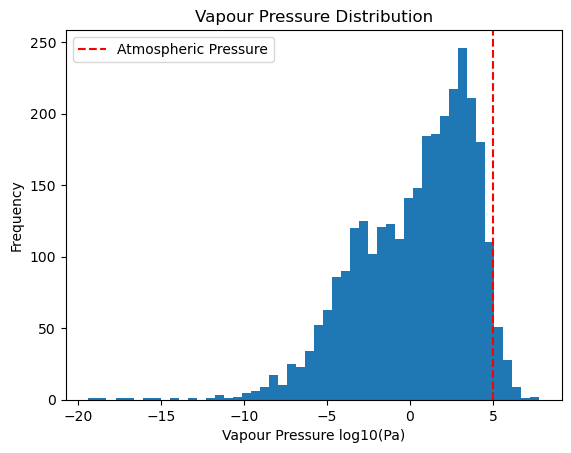

In [182]:
#histogram of vp form df
import matplotlib.pyplot as plt
plt.hist(df['vp_log10_pa'],bins=50)
#axis labels
plt.xlabel('Vapour Pressure log10(Pa)')
plt.ylabel('Frequency')
plt.title('Vapour Pressure Distribution')
#also draw a line at 5 (atmospheric pressure)
plt.axvline(x=np.log10(101325), color='r', linestyle='--')
#legend
plt.legend(['Atmospheric Pressure'])
plt.show()


In [170]:
ethane = Chem.MolFromSmiles('CC')
mwt_ethane = Chem.Descriptors.ExactMolWt(ethane)
mwt_ethane/22.4

1.341381705

In [184]:
opera['inchikey'] = opera['SMILES'].apply(lambda x: Chem.MolToInchiKey(ChargeParent(Chem.MolFromSmiles(x))))
opera

[14:46:52] Initializing MetalDisconnector
[14:46:52] Running MetalDisconnector
[14:46:52] Initializing Normalizer
[14:46:52] Running Normalizer
[14:46:52] Running LargestFragmentChooser
[14:46:52] Running Uncharger
[14:46:52] Initializing MetalDisconnector
[14:46:52] Running MetalDisconnector
[14:46:52] Initializing Normalizer
[14:46:52] Running Normalizer
[14:46:52] Initializing MetalDisconnector
[14:46:52] Running MetalDisconnector
[14:46:52] Initializing Normalizer
[14:46:52] Running Normalizer
[14:46:52] Running LargestFragmentChooser
[14:46:52] Running Uncharger
[14:46:52] Initializing MetalDisconnector
[14:46:52] Running MetalDisconnector
[14:46:52] Initializing Normalizer
[14:46:52] Running Normalizer
[14:46:52] Initializing MetalDisconnector
[14:46:52] Running MetalDisconnector
[14:46:52] Initializing Normalizer
[14:46:52] Running Normalizer
[14:46:52] Running LargestFragmentChooser
[14:46:52] Running Uncharger
[14:46:52] Initializing MetalDisconnector
[14:46:52] Running MetalD

,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar,inchikey
15,CC=C(C)C(=O)O,-0.874799,NaN,NaN,NaN,NaN,198.5,NaN,NaN,NaN,NaN,NaN,NaN,64.5,NaN,UIERETOOQGIECD-UHFFFAOYSA-N
19,CCCC(=NOCC)C1C(=O)CC(C2CCCSC2)CC1=O,-7.124900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,-3.850493,GOJRHLKLWMSXMB-UHFFFAOYSA-N
24,CCCC(C)(C)C,2.021202,NaN,-11.472370,NaN,0.8451,79.2,NaN,NaN,NaN,NaN,NaN,NaN,-123.8,-4.359006,CXOWYJMDMMMMJO-UHFFFAOYSA-N
36,COc1c(O)cc(Cl)c(Cl)c1Cl,-3.045800,3.77,NaN,2.41,NaN,NaN,NaN,NaN,NaN,0.11,NaN,2.8,NaN,-2.869666,RKEHLKXRUVUBJN-UHFFFAOYSA-N
47,CC(C)(N=C=O)c1cccc(C(C)(C)N=C=O)c1,-2.494900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AZYRZNIYJDKRHO-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18514,CCOS(C)(=O)=O,-0.686099,NaN,NaN,NaN,NaN,213.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLUBXMRUUVWRLT-UHFFFAOYSA-N
18520,C=CC(=O)OC,1.937300,0.80,NaN,NaN,NaN,80.2,NaN,NaN,NaN,NaN,NaN,NaN,-76.5,-0.230572,BAPJBEWLBFYGME-UHFFFAOYSA-N
18543,CC(CCO)CC(C)(C)C,-0.522900,NaN,NaN,NaN,NaN,194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BODRLKRKPXBDBN-UHFFFAOYSA-N
18550,CC(C)=CC1C(C(=O)OCN2C(=O)C3=C(CCCC3)C2=O)C1(C)C,-5.150000,4.73,NaN,NaN,NaN,NaN,1.575188,0.0025,NaN,NaN,NaN,NaN,69.0,-5.192408,CXBMCYHAMVGWJQ-UHFFFAOYSA-N


In [185]:
df['inchikey'] = df['molblock'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromMolBlock(x)))
df

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles,inchikey
0,2390,2388,2.325202,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24....",[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef1e1700>,C=C1C=C[C@H](C(C)C)CC1,LFJQCDVYDGGFCH-JTQLQIEISA-N
1,2396,2394,2.092402,"{'mdfp': '[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.74...",[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef1e18c0>,CCCCCCO,ZSIAUFGUXNUGDI-UHFFFAOYSA-N
2,2399,2397,-3.979000,"{'mdfp': '[19, 1, 0, 0, 0, 0, 0, 7, 0, 0, -18....",[H]c1c(Cl)c(Cl)c(Cl)c(-c2c([H])c(Cl)c(Cl)c(Cl)...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef1e1930>,Clc1cc(-c2c(Cl)cc(Cl)c(Cl)c2Cl)cc(Cl)c1Cl,TVFXBXWAXIMLAQ-UHFFFAOYSA-N
3,2422,2420,3.031002,"{'mdfp': '[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.2...",[H]c1nc([H])c(C([H])([H])[H])nc1[H]\n RDKi...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef1e19a0>,Cc1cnccn1,CAWHJQAVHZEVTJ-UHFFFAOYSA-N
4,2400,2398,2.056402,"{'mdfp': '[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -30....",[H]c1c([H])c(C([H])([H])C([H])([H])[H])c(C([H]...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef1e1a10>,CCc1ccc(C)cc1C,MEMBJMDZWKVOTB-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...
3045,2690,2688,3.725002,"{'mdfp': '[7, 1, 0, 0, 0, 0, 0, 0, 0, 0, -2.05...",[H]C([H])([H])C([H])([H])C1([H])C([H])([H])C([...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef286810>,CCC1CCCC1,IFTRQJLVEBNKJK-UHFFFAOYSA-N
3046,2758,2756,2.352403,"{'mdfp': '[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, -25.6...",[H]c1c([H])c(C([H])([H])[H])c(C([H])([H])[H])c...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef286880>,Cc1cccc(C)c1C,FYGHSUNMUKGBRK-UHFFFAOYSA-N
3047,2801,2799,3.181803,"{'mdfp': '[6, 0, 0, 0, 0, 0, 1, 0, 0, 0, -5.63...",[H]SC1([H])C([H])([H])C([H])([H])C([H])([H])C1...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef2868f0>,SC1CCCC1,WVDYBOADDMMFIY-UHFFFAOYSA-N
3048,2829,2827,-3.416498,"{'mdfp': '[9, 4, 0, 4, 0, 0, 0, 0, 0, 0, -320....",[H]OC(=O)C([H])([H])C([H])([H])C([H])([H])C(=O...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef286960>,O=C(O)CCCC(=O)O,JFCQEDHGNNZCLN-UHFFFAOYSA-N


In [191]:
#combine on inchikey
combined = pd.merge(df,opera,how='inner',on='inchikey')
combined
#get confirmed liquids (bp < 25, mp > 25)
liquids = combined[(combined['MP'] < 25) & (combined['BP'] > 25)]

liquids_molregnos = liquids['molregno'].values

In [248]:
liquids = combined[(combined['MP'] < 25) & (combined['BP'] > 25)]
solids = combined[(combined['MP'] > 25)]
gases = combined[(combined['BP'] < 25)]
len(liquids),len(solids),len(gases),len(combined)

(788, 591, 70, 1864)

In [255]:
#get len of combined where MP is not nan
len(combined[~combined['MP'].isna()])

1496

In [244]:
len(liquids),len(combined)

(788, 1864)

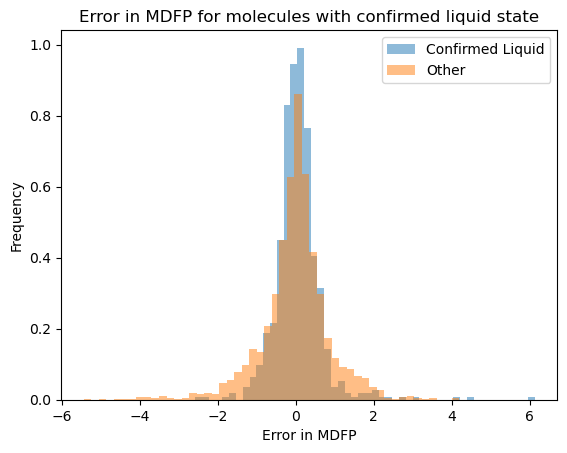

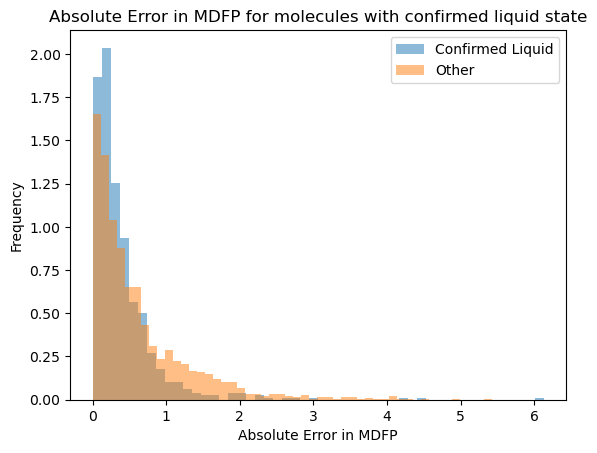

In [203]:
df_pred_results = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_PhysChem_MDFP_MDFP_PhysChem.csv')
df_pred_results
#average over molregno
df_pred_results_avg = df_pred_results.groupby('molregno').mean()
df_pred_results_avg
#plot error_MDFP for molregno in liquids_molregnos vs the others (histograms)
plt.hist(df_pred_results_avg[df_pred_results_avg.index.isin(liquids_molregnos)]['error_MDFP'],bins=50,alpha=0.5,density=True)
plt.hist(df_pred_results_avg[~df_pred_results_avg.index.isin(liquids_molregnos)]['error_MDFP'],bins=50,alpha=0.5,density=True)
plt.xlabel('Error in MDFP')
plt.ylabel('Frequency')
plt.title('Error in MDFP for molecules with confirmed liquid state')
plt.legend(['Confirmed Liquid','Other'])
plt.show()

#same with absolute errors
plt.hist(np.abs(df_pred_results_avg[df_pred_results_avg.index.isin(liquids_molregnos)]['error_MDFP']),bins=50,alpha=0.5,density=True)
plt.hist(np.abs(df_pred_results_avg[~df_pred_results_avg.index.isin(liquids_molregnos)]['error_MDFP']),bins=50,alpha=0.5,density=True)
plt.xlabel('Absolute Error in MDFP')
plt.ylabel('Frequency')
plt.title('Absolute Error in MDFP for molecules with confirmed liquid state')
plt.legend(['Confirmed Liquid','Other'])
plt.show()


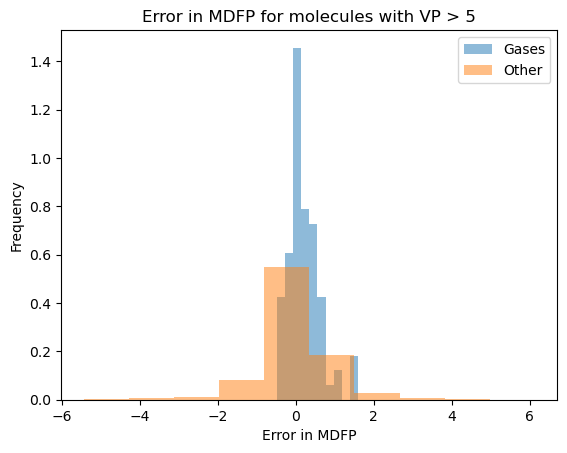

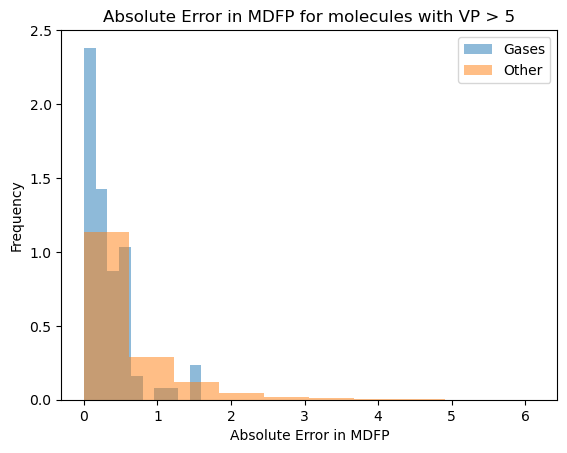

In [204]:
#same with vp > 5 vs others
vp_5_molregnos = df[df['vp_log10_pa'] > 5]['molregno'].values
plt.hist(df_pred_results_avg[df_pred_results_avg.index.isin(vp_5_molregnos)]['error_MDFP'],bins=10,alpha=0.5,density=True)
plt.hist(df_pred_results_avg[~df_pred_results_avg.index.isin(vp_5_molregnos)]['error_MDFP'],bins=10,alpha=0.5,density=True)
plt.xlabel('Error in MDFP')
plt.ylabel('Frequency')
plt.title('Error in MDFP for molecules with VP > 5')
plt.legend(['Gases','Other'])
plt.show()

#same with absolute errors
plt.hist(np.abs(df_pred_results_avg[df_pred_results_avg.index.isin(vp_5_molregnos)]['error_MDFP']),bins=10,alpha=0.5,density=True)
plt.hist(np.abs(df_pred_results_avg[~df_pred_results_avg.index.isin(vp_5_molregnos)]['error_MDFP']),bins=10,alpha=0.5,density=True)
plt.xlabel('Absolute Error in MDFP')
plt.ylabel('Frequency')
plt.title('Absolute Error in MDFP for molecules with VP > 5')
plt.legend(['Gases','Other'])
plt.show()

In [195]:
#save confirmed liquid molregnos as list as pickle
import pickle
with open('confirmed_liquids.pkl','wb') as f:
    pickle.dump(liquids_molregnos,f)

#load
with open('confirmed_liquids.pkl','rb') as f:
    liquids_molregnos = pickle.load(f)

In [198]:
df_gasses.sort_values('vp_log10_pa',ascending=True).head(20)

,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles
355,16957,16955,5.002802,"{'mdfp': '[8, 2, 0, 0, 5, 0, 0, 0, 0, 0, 47.97...",[H]C([H])(F)C(F)(F)C([H])(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef237f40>,FCC(F)(F)C(F)F
2539,3186,3184,5.029502,"{'mdfp': '[5, 0, 0, 0, 1, 0, 0, 3, 0, 0, -0.00...",FC(Cl)(Cl)Cl\n RDKit 3D\n\n 0 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef277c30>,FC(Cl)(Cl)Cl
2441,844,1989,5.034702,"{'mdfp': '[3, 0, 1, 1, 0, 0, 0, 0, 0, 0, -95.2...",[H]N=C=O\n RDKit 3D\n\n 0 0 0 ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef275070>,N=C=O
436,628,1773,5.038202,"{'mdfp': '[4, 0, 0, 0, 0, 0, 0, 1, 0, 0, -26.4...",[H]C([H])=C(Cl)C([H])([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef23a490>,C=C(C)Cl
264,15867,15865,5.046000,"{'mdfp': '[15, 0, 0, 0, 10, 0, 0, 0, 0, 0, 6.3...",FC1(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef2354d0>,FC1(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F
1492,15920,15918,5.070000,"{'mdfp': '[11, 0, 0, 0, 8, 0, 1, 0, 0, 0, -3.1...",FC(F)(F)S(F)(F)C(F)(F)F\n RDKit 3...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef259770>,FC(F)(F)S(F)(F)C(F)(F)F
201,3646,3644,5.074502,"{'mdfp': '[6, 0, 0, 0, 2, 0, 0, 2, 0, 0, 10.18...",F/C(Cl)=C(/F)Cl\n RDKit 3D\n\n 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef2337d0>,F/C(Cl)=C(/F)Cl
646,15921,15919,5.079000,"{'mdfp': '[3, 0, 0, 0, 0, 0, 0, 1, 0, 0, -3.49...",[H]C([H])([H])C([H])([H])Cl\n RDKit ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef240890>,CCCl
235,16858,16856,5.080102,"{'mdfp': '[3, 0, 0, 1, 0, 0, 0, 0, 0, 0, -46.0...",[H]C(=O)C([H])([H])[H]\n RDKit 3D...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef2347b0>,CC=O
2500,2789,2787,5.080402,"{'mdfp': '[5, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1.27...",[H]C([H])=C([H])C([H])(C([H])([H])[H])C([H])([...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef276b20>,C=CC(C)C


In [207]:
#get the others
df_not_gas = df[~df['molregno'].isin(df_gasses['molregno'].values)]
#get smalles molecule (lowest number of heavy atoms)
df_not_gas['NumHeavyAtoms'] = df_not_gas['molblock'].apply(lambda x: Chem.MolFromMolBlock(x).GetNumHeavyAtoms())
df_not_gas.sort_values('NumHeavyAtoms',ascending=True).head(20) 

/tmp/ipykernel_2886985/997178864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_gas['NumHeavyAtoms'] = df_not_gas['molblock'].apply(lambda x: Chem.MolFromMolBlock(x).GetNumHeavyAtoms())


,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid,ROMol,smiles,inchikey,NumHeavyAtoms
2924,16025,16023,4.179000,"{'mdfp': '[2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 17.51...",[H]SS[H]\n RDKit 3D\n\n 0 0 0 ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef283060>,SS,BWGNESOTFCXPMA-UHFFFAOYSA-N,2
1125,16389,16387,2.476000,"{'mdfp': '[2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 84.75...",[H]OO[H]\n RDKit 3D\n\n 0 0 0 ...,26dee5cf-c401-4924-9c43-6e5f8f311763,2153b1f8-cb83-4974-86a3-249f49ab55b7,<rdkit.Chem.rdchem.Mol object at 0x7732ef24e7a0>,OO,MHAJPDPJQMAIIY-UHFFFAOYSA-N,2
799,431,1576,4.732402,"{'mdfp': '[2, 0, 0, 0, 0, 0, 0, 0, 0, 1, -0.24...",[H]C([H])([H])I\n RDKit 3D\n\n 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef244f20>,CI,INQOMBQAUSQDDS-UHFFFAOYSA-N,2
763,3150,3148,4.228702,"{'mdfp': '[2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 16.73...",[H]OC([H])([H])[H]\n RDKit 3D\n\n...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef243e60>,CO,OKKJLVBELUTLKV-UHFFFAOYSA-N,2
2509,2911,2909,2.347103,"{'mdfp': '[3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 110.3...",[H]ON([H])C([H])([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef276f10>,CNO,CPQCSJYYDADLCZ-UHFFFAOYSA-N,3
2541,3215,3213,4.763402,"{'mdfp': '[3, 0, 0, 0, 0, 0, 0, 2, 0, 0, -0.12...",[H]C([H])(Cl)Cl\n RDKit 3D\n\n 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef277d10>,ClCCl,YMWUJEATGCHHMB-UHFFFAOYSA-N,3
971,3092,3090,3.823902,"{'mdfp': '[3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 174.3...",[H]N([H])N([H])C([H])([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef24a030>,CNN,HDZGCSFEDULWCS-UHFFFAOYSA-N,3
2387,151,1296,4.588902,"{'mdfp': '[3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 37.01...",[H]N([H])OC([H])([H])[H]\n RDKit ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef2736f0>,CON,GMPKIPWJBDOURN-UHFFFAOYSA-N,3
17,3369,3367,3.754202,"{'mdfp': '[3, 0, 0, 2, 0, 0, 0, 0, 0, 0, -79.8...",[H]OC([H])=O\n RDKit 3D\n\n 0 0...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef1e2030>,O=CO,BDAGIHXWWSANSR-UHFFFAOYSA-N,3
189,3547,3545,2.204101,"{'mdfp': '[3, 0, 0, 0, 0, 0, 0, 0, 0, 2, -0.23...",[H]C([H])(I)I\n RDKit 3D\n\n 0 ...,fc57851e-b654-4338-bcdd-faa28ec66253,906589dd-76fa-4d7b-aa9f-1ee90abe3835,<rdkit.Chem.rdchem.Mol object at 0x7732ef233220>,ICI,NZZFYRREKKOMAT-UHFFFAOYSA-N,3


In [210]:
#our smallest molecule is probaby methane
rdk_pmd_methanol_100 = LiquidParameteriser.via_rdkit(smiles = 'CO', num_lig = 100)
rdk_pmd_methanol_100.box_vectors

Quantity(value=([21.535, 0.0, 0.0], [0, 21.535, 0.0], [0, 0, 21.535]), unit=angstrom)

In [214]:
simulation,system = start_sim(rdk_pmd_methanol_100,file_name='methanol_100')

OpenMMException: The periodic box size has decreased to less than twice the nonbonded cutoff.

In [215]:
#our smallest molecule is probaby methane
rdk_pmd_methanol_256 = LiquidParameteriser.via_rdkit(smiles = 'CO', num_lig = 256)
simulation,system = start_sim(rdk_pmd_methanol_256,file_name='methanol_256')

KeyboardInterrupt: 

In [222]:
#and get box size at last frame
df_production_methanol_256 = pd.read_csv('production_methanol_256.dat')
df_production_methanol_256
#get vector (box volumn in nm3 to axis in armstrong)
box_volumne_nm3 = 17.7
box_size_nm = box_volumne_nm3**(1/3)
box_size_armstrong = box_size_nm * 10
box_size_armstrong

26.06100075337349

In [227]:
rdk_pmd_methanol_256.box_vectors

Quantity(value=([26.061643424729407, 0.0, 0.0], [0, 26.061643424729407, 0.0], [0, 0, 26.061643424729407]), unit=angstrom)

In [249]:
smiles_uracil = 'O=C1CC=NC(=O)N1'
rdk_pmd_uracil = LiquidParameteriser.via_rdkit(smiles = smiles_uracil)
start_sim(rdk_pmd_uracil,file_name='uracil_again')

In [251]:
smiles_adamantane = 'C1C3CC2CC(CC1C2)C3'
rdk_pmd_adamantane = LiquidParameteriser.via_rdkit(smiles = smiles_adamantane)
start_sim(rdk_pmd_adamantane,file_name='adamantane',write_out_freq=5000)

KeyboardInterrupt: 

In [252]:
#save top as pdb
rdk_pmd_adamantane.save('adamantane.pdb')
traj = md.load('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/adamantane.h5')
traj.save_dcd('adamantane.dcd')


/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [253]:
smiles_Naphthalene = "c1c2ccccc2ccc1"
rdk_pmd_Naphthalene= LiquidParameteriser.via_rdkit(smiles = smiles_Naphthalene)
start_sim(rdk_pmd_Naphthalene,file_name='Naphthalene',write_out_freq=5000)

KeyboardInterrupt: 

In [254]:
#save top as pdb
rdk_pmd_Naphthalene.save('Naphthalene.pdb')
traj = md.load('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/Naphthalene.h5')
traj.save_dcd('Naphthalene.dcd')


/localhome/cschiebroek/.conda/envs/openff_evaluator_clone/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


In [1]:
#now we need to register these two mols, and run the simulations.
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [3]:
lwreg.query(smiles='c1ccccc1',config=config)

[1]

In [6]:
lwreg.query(ids=[1],config=config)

[(1, 2298), (1, 7191), (1, 15658), (1, 15659), (1, 15660), (1, 15662)]